In [1]:
import itertools
import json
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import set_config
set_config(display='diagram')

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.pipeline import Pipeline

In [2]:
# read in training data and drop labels for text-only
train = pd.read_csv('../data/final/train.csv')
X = train.drop(labels=['review_text', 'w2v_feat', 'target', 't_subjectivity', 'negative', 'positive', 'neutral', 't_n_tokens', 't_polarity', 't_compound', 't_rating'], axis=1)
y = train['target']

In [3]:
# define pipeline elements
tfidf_preproc = ColumnTransformer([('vectorizer', TfidfVectorizer(), 'lemma_sent')])
classifier = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [4]:
# grid search on a handful of parameters and define the full pipeline
param_grid = {
    'preprocessor__vectorizer__max_features': [1000, 2500, 5000, 7500],
    'preprocessor__vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'preprocessor__vectorizer__max_df': [.25, .5, .75, 1.0],
}

pipe = Pipeline([
    ('preprocessor', tfidf_preproc),
    ('classifier', classifier)
])

gs_model = GridSearchCV(
    pipe, 
    cv=5, 
    n_jobs=1, 
    param_grid=param_grid, 
    scoring='recall', 
    error_score='raise', 
    verbose=2
)

In [5]:
gs_model.fit(X, y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END preprocessor__vectorizer__max_df=0.25, preprocessor__vectorizer__max_features=1000, preprocessor__vectorizer__ngram_range=(1, 1); total time=   0.7s
[CV] END preprocessor__vectorizer__max_df=0.25, preprocessor__vectorizer__max_features=1000, preprocessor__vectorizer__ngram_range=(1, 1); total time=   0.7s
[CV] END preprocessor__vectorizer__max_df=0.25, preprocessor__vectorizer__max_features=1000, preprocessor__vectorizer__ngram_range=(1, 1); total time=   0.8s
[CV] END preprocessor__vectorizer__max_df=0.25, preprocessor__vectorizer__max_features=1000, preprocessor__vectorizer__ngram_range=(1, 1); total time=   0.6s
[CV] END preprocessor__vectorizer__max_df=0.25, preprocessor__vectorizer__max_features=1000, preprocessor__vectorizer__ngram_range=(1, 1); total time=   0.6s
[CV] END preprocessor__vectorizer__max_df=0.25, preprocessor__vectorizer__max_features=1000, preprocessor__vectorizer__ngram_range=(1, 2); total tim

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('vectorizer',
                                                                         TfidfVectorizer(),
                                                                         'lemma_sent')])),
                                       ('classifier',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           random_state=42))]),
             n_jobs=1,
             param_grid={'preprocessor__vectorizer__max_df': [0.25, 0.5, 0.75,
                                                              1.0],
                         'preprocessor__vectorizer__max_features': [1000, 2500,
                                                                    5000,
                                                                    7500],
                         'preprocessor__vectorizer__ngram_range': [(1, 1),
                                                                   (1, 2),
                                                                   (1, 3)]},
             scoring='recall', verbose=2)

In [6]:
print(gs_model.best_params_)

{'preprocessor__vectorizer__max_df': 0.5, 'preprocessor__vectorizer__max_features': 1000, 'preprocessor__vectorizer__ngram_range': (1, 1)}


In [7]:
# output best score, params, and estimator
print(gs_model.best_score_)

0.833569299781854


In [8]:
print(gs_model.best_estimator_)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('vectorizer',
                                                  TfidfVectorizer(max_df=0.5,
                                                                  max_features=1000),
                                                  'lemma_sent')])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])


In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 fontsize=12,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

Classification Report : Logistic Regression (TFIDF)

-------------------------------------
                 precision    recall  f1-score   support

    recommended       0.96      0.85      0.90     12994
not-recommended       0.55      0.83      0.66      2854

       accuracy                           0.85     15848
      macro avg       0.75      0.84      0.78     15848
   weighted avg       0.88      0.85      0.86     15848

Confusion Matrix : Logistic Regression (TFIDF)

-------------------------------------


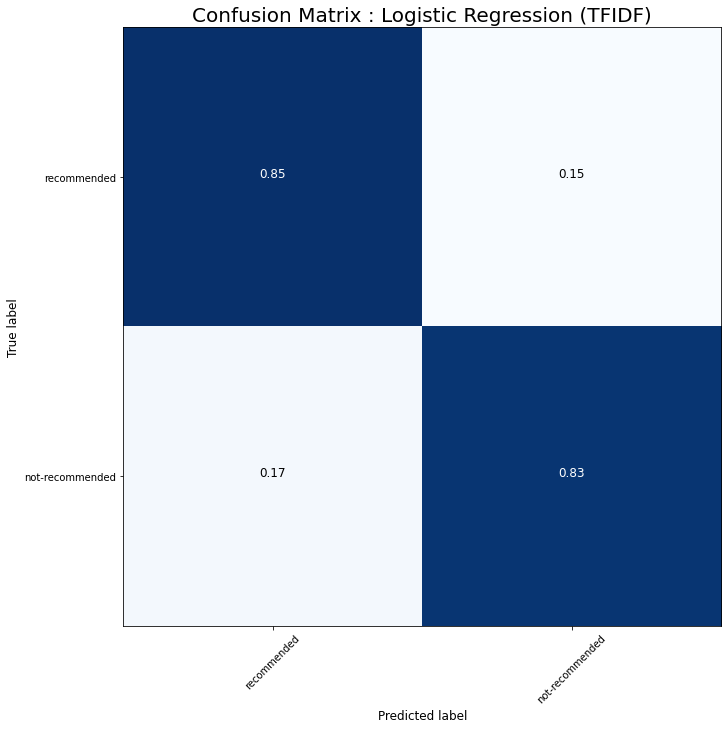

In [10]:
# print classification reports
TARGETS = ['recommended', 'not-recommended']

y_pred = cross_val_predict(gs_model.best_estimator_, X, y)
print(f'Classification Report : Logistic Regression (TFIDF)\n')
print('-------------------------------------')
print(classification_report(y, y_pred, target_names=TARGETS))

# print confusion matrices
print(f'Confusion Matrix : Logistic Regression (TFIDF)\n')
print('-------------------------------------')
plot_confusion_matrix(confusion_matrix(y, y_pred), classes=['recommended','not-recommended'], normalize=True, title=f'Confusion Matrix : Logistic Regression (TFIDF)')
plt.grid(False)
plt.savefig(f'../assets/tfidf_{"Logistic Regression (TFIDF)".lower()}.png')
plt.show()

In [11]:
joblib.dump(gs_model.best_estimator_, '../models/logistic-regression-tuned.joblib')

['../models/logistic-regression-tuned.joblib']